# 0. new change is in section 3. data argument: mixup
1. add mixup (3.data augment/train/Exp2:res164_v2 + DA2 + mixup)</br>
2. add num_workers to dataloader </br>
3. add resnet152_v2 fintune exp</br>

## 0.0 TODO list

#### resnet164_e300_mixup实验效果不好


# 1. import needed package and set global env

you need to download CIFAR10 dataset from kaggle and then extract to \${data_dir}, (such as "/root/Workspace/data/CIFAR10_kaggle/")<br/>
\${data_dir} should like this(dir "train_valid_test" will generate in data prepared model):</br>
![](../../_image/data_dir.png)<br/>
and then set variable
```
set var data_dir=${data_dir}
```

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

# data_dir = "/root/Workspace/data/CIFAR10_kaggle/"
data_dir = "/home/hui/dataset/CIFAR10_kaggle/"
train_dir = "train"
test_dir = "test"
label_file = "trainLabels.csv"
input_dir = 'train_valid_test/'
valid_ratio = 0.1
batch_size = 32

force_recreate_dir = False

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data prepared(need not run this block repeatly)
if you have do dataset prepared and generate 'train_valid_test' dir to orgnize data, just ignore this block(that mean you need not run this model and just skip it)<br/>

the step may cost about 40~60min.<br/>

so to avoid run this model repeatly, we check the created dir, and if exist will not create again, if you want to recreate them, set force_recreate_dir=True.<br/>

In [2]:
"""
data prepare, reference to http://zh.gluon.ai/chapter_computer-vision/kaggle-gluon-cifar10.html
"""
def reorg_cifar10_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
    with open(os.path.join(data_dir, label_file), 'r') as f:
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        idx_label = dict((int(idx), label)for idx, label in tokens)
    labels = set(idx_label.values())
    print labels
    
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = int(num_train * (1 - valid_ratio))
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    label_count = dict()
    
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
    
    # copy to create train set and valid set and train_valid set (train/label, valid/label, train_valid/label)
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                  os.path.join(data_dir, input_dir, 'train_valid', label))
        if label_count.get(label, 0) < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', label))
    
    # copy to create test set (test/unkown)
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unkown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        shutil.copy(os.path.join(data_dir, test_dir, test_file), 
                   os.path.join(data_dir, input_dir, 'test', 'unkown'))


if force_recreate_dir==False and os.path.exists(data_dir + input_dir) and os.path.exists(data_dir + input_dir + train_dir) and os.path.exists(data_dir + input_dir + test_dir):
    print "train_valid_test dir has been created and if you want to recreate them",
    print "set force_recreate=True(normally you needn't to do it.)"
else:
    reorg_cifar10_data(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio)

train_valid_test dir has been created and if you want to recreate them set force_recreate=True(normally you needn't to do it.)


# 3. data loader, data argument

In [3]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = vision.ImageFolderDataset(data_dir + "/" + input_dir + '/train', flag=1, transform=transform_train)
    valid_ds = vision.ImageFolderDataset(data_dir + "/" + input_dir + '/valid', flag=1, transform=transform_test)
    train_valid_ds = vision.ImageFolderDataset(data_dir + "/" + input_dir + '/train_valid', flag=1, transform=transform_train)
    test_ds = vision.ImageFolderDataset(data_dir + "/" + input_dir + "/test", flag=1, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    valid_data = loader(valid_ds, batch_size, shuffle=True, last_batch='keep')
    train_valid_data = loader(train_valid_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep')
    return train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds

In [4]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [5]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [6]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train)
mixup_train_data, _, _, _, _, _ = data_loader(batch_size, transform_train)
mixup_alpha = 0.2

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

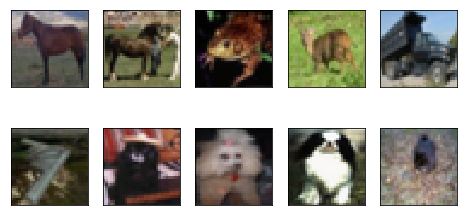

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.03008456  0.          0.          0.          0.          0.
    0.96991545  0.          0.        ]]

 [[ 0.          0.          0.03008456  0.          0.          0.          0.
    0.96991545  0.          0.        ]]

 [[ 0.          0.          0.          0.          0.03008456  0.
    0.96991545  0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.96991545  0.          0.
    0.          0.          0.03008456]]

 [[ 0.          0.          0.03008456  0.          0.          0.          0.
    0.          0.          0.96991545]]

 [[ 0.96991545  0.          0.          0.          0.          0.03008456
    0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.03008456  0.          0.96991545
    0.          0.          0.          0.       

In [7]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [10]:
from time import time
net = ResNet164_v2(10)
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

num_epochs = 1
learning_rate = 0.1
weight_decay = 1e-4

cur_time = time()
iters = 0
"""
data loader first time run will cost about 3x time than after run.
"""
for x1, y1 in train_data:
    if iters % 100 == 0:
        print iters, time() - cur_time
    iters += 1
print "cost time:", time() - cur_time
print
cur_time = time()

iters = 0
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    
    with autograd.record():
        output = net(data.as_in_context(ctx))
        loss = loss_f(output, label.as_in_context(ctx))
    loss.backward()
    trainer.step(data.shape[0])
    
    if iters % 100 == 0:
        print iters, time() - cur_time, nd.mean(loss).asscalar()
    iters += 1
print iters, time() - cur_time

# load data one by one batch
# iters = 0
# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
#         break
#     if iters % 100 == 0:
#         print iters, time() - cur_time
#     iters += 1
# print "cost time:", time() - cur_time
# print
# cur_time = time()

# zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
# iters = 0
# for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
#     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#     if iters % 100 == 0:
#         print iters, time() - cur_time#, nd.mean(loss).asscalar()
#     iters += 1
# print time() - cur_time

 0 0.0270001888275
100 1.62204909325
200 3.26104807854
300 4.93760609627
400 6.54733014107
500 8.17929911613
600 9.80246806145
700 11.3888339996
800 12.9344990253
900 14.4871020317
1000 16.0459091663
1100 17.59375
1200 19.1476790905
1300 20.7648742199
1400 22.3346571922
cost time: 22.4168221951

0 0.695066928864 2.40384
100 14.5559430122 2.39587
200 28.7656300068 1.75842
300 43.0961830616 2.22745
400 57.5903449059 1.73206
500 71.7800679207 1.95165
600 87.3415601254 1.74515
700 102.235950947 2.10155
800 117.461390018 1.48667
900 132.76970005 1.29023
1000 147.590975046 1.69018
1100 162.804922104 1.68614
1200 177.191309929 1.53035
1300 192.143471003 1.70047
1400 206.757816076 1.77822
1407 207.651305914


# 4. define train function

In [8]:
"""
train
"""
import datetime
import utils
import sys

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2):
    def train_batch(data, label, i):
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i)
                train_loss += _loss
                i += 1
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP
the model define in netlib.py, just invoke to create it, and not use any pretrain model<br/>

#### note: if you just want to got a submission result, just ignore Exp1~5

### Exp1: res164_v2 + DA1: 0.9529

In [ ]:
batch_size = 128
transform_train = transform_train_DA1
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train)
net = ResNet164_v2(10)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [90, 140]
lr_decay=0.1
log_file = None

net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)

net.save_params("../../models/shelock_resnet_orign")

### Exp2:res164_v2 + DA2: 0.9527

In [ ]:
batch_size = 128
transform_train = transform_train_DA2
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train2)
net = ResNet164_v2(10)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 300
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [150, 225]
lr_decay=0.1
log_file = None

net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/resnet164_e300")

#### Exp2:res164_v2 + DA2 + mixup

In [ ]:
batch_size = 128
transform_train = transform_train_DA2
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train_DA2)
net = ResNet164_v2(10)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

num_epochs = 300
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [150, 225]
lr_decay=0.1
log_file = "../../log/resnet164_e300_mixup.log"

net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, True, loss_f, use_mixup=True)
net.save_params("../../models/resnet164_e300_mixup")

### Exp3: res164_v2 + focal loss + DA3: 0.9540

In [ ]:
batch_size = 128
tranform_train = transform_train_DA3
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train)
net = ResNet164_v2(10)
loss_f = FocalLoss()

num_epochs = 255
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [150, 225]
lr_decay=0.1
log_file = None

net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
w_key = []
train(net, train_valid_data, None, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/res164__2_e255_focal_clip_all_data")

### Exp4: res164_v2 + focal loss + DA3 + only train_data: 0.9506

In [ ]:
batch_size = 128
transform_train = transform_train_DA3
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train)
net = ResNet164_v2(10)
loss_f = FocalLoss()

num_epochs = 255
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [150, 225]
lr_decay=0.1
log_file = None

net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/resnet164_e0-255_focal_clip")

### Exp5: sherlock_densenet: 0.9539

In [ ]:
batch_size = 128
transform_train = transform_train_DA1
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train)
net = DenseNet(growthRate=12, depth=100, reduction=0.5, bottleneck=True, nClasses=10)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [90, 140]
lr_decay=0.1
log_file = None

net.hybridize()
net.initialize(ctx=ctx)
w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/shelock_densenet_orign")

### Exp6: resnet

In [20]:
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn

# create and add must in name_scope, or may got name error
net = nn.HybridSequential()
with net.name_scope():
    resnet = model.resnet152_v2(pretrained=True, ctx=ctx)
    output = nn.Dense(10)
    net.add(resnet.features)
    net.add(output)

net.hybridize()
output.initialize(ctx=ctx)

In [21]:
batch_size = 128
transform_train = transform_train_DA2
train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(batch_size, transform_train_DA2)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

num_epochs = 200  # iters=20*1400
learning_rate = 0.01
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None

w_key = []
train(net, train_data, valid_data, num_epochs, learning_rate, 
      lr_period, lr_decay, weight_decay, ctx, w_key, log_file, False, loss_f)
net.save_params("../../models/resnet152_v2_finetune")

epoch 0, loss 2.36188, train_acc 0.1796, valid_acc 0.1635, Time 00:02:25,lr 0.01
epoch 1, loss 2.40337, train_acc 0.1646, valid_acc 0.2199, Time 00:01:44,lr 0.01
epoch 2, loss 2.32695, train_acc 0.1871, valid_acc 0.2805, Time 00:01:44,lr 0.01
epoch 3, loss 2.24258, train_acc 0.2184, valid_acc 0.2588, Time 00:01:46,lr 0.01
epoch 4, loss 2.16632, train_acc 0.2387, valid_acc 0.3346, Time 00:01:46,lr 0.01
epoch 5, loss 2.14873, train_acc 0.2413, valid_acc 0.3400, Time 00:01:49,lr 0.01
epoch 6, loss 2.11275, train_acc 0.2560, valid_acc 0.3193, Time 00:01:48,lr 0.01
epoch 7, loss 2.03341, train_acc 0.2752, valid_acc 0.3453, Time 00:01:45,lr 0.01
epoch 8, loss 1.98142, train_acc 0.2915, valid_acc 0.3854, Time 00:01:45,lr 0.01
epoch 9, loss 1.92689, train_acc 0.3094, valid_acc 0.4088, Time 00:01:43,lr 0.01
epoch 10, loss 1.86411, train_acc 0.3292, valid_acc 0.4117, Time 00:01:44,lr 0.01
epoch 11, loss 1.83029, train_acc 0.3408, valid_acc 0.4480, Time 00:01:43,lr 0.01
epoch 12, loss 1.79810, tr

epoch 100, loss 0.41774, train_acc 0.8539, valid_acc 0.8293, Time 00:01:42,lr 0.001
epoch 101, loss 0.41799, train_acc 0.8545, valid_acc 0.8279, Time 00:01:42,lr 0.001
epoch 102, loss 0.41279, train_acc 0.8566, valid_acc 0.8273, Time 00:01:42,lr 0.001
epoch 103, loss 0.41512, train_acc 0.8551, valid_acc 0.8260, Time 00:01:42,lr 0.001
epoch 104, loss 0.41091, train_acc 0.8598, valid_acc 0.8254, Time 00:01:42,lr 0.001
epoch 105, loss 0.40518, train_acc 0.8584, valid_acc 0.8287, Time 00:01:42,lr 0.001
epoch 106, loss 0.40242, train_acc 0.8619, valid_acc 0.8293, Time 00:01:42,lr 0.001
epoch 107, loss 0.39534, train_acc 0.8624, valid_acc 0.8215, Time 00:01:42,lr 0.001
epoch 108, loss 0.40286, train_acc 0.8605, valid_acc 0.8324, Time 00:01:42,lr 0.001
epoch 109, loss 0.39811, train_acc 0.8623, valid_acc 0.8240, Time 00:01:41,lr 0.001
epoch 110, loss 0.39283, train_acc 0.8631, valid_acc 0.8330, Time 00:01:42,lr 0.001
epoch 111, loss 0.39593, train_acc 0.8629, valid_acc 0.8254, Time 00:01:43,l

epoch 197, loss 0.26736, train_acc 0.9093, valid_acc 0.8357, Time 00:01:42,lr 0.0001
epoch 198, loss 0.26660, train_acc 0.9091, valid_acc 0.8389, Time 00:01:42,lr 0.0001
epoch 199, loss 0.26477, train_acc 0.9104, valid_acc 0.8350, Time 00:01:42,lr 0.0001


# 6. result
to run this two block, you need at least five model params file, name as follow in model dir.
```
model_list = ['res164__2_e255_focal_clip_all_data', 'resnet164_e300', 'resnet164_e0-255_focal_clip',
              'shelock_densenet_orign', 'shelock_resnet_orign']
```
you can train from **5. get net and do EXP**, or you can download them from
```
link: https://pan.baidu.com/s/1pLjzQWj key: f6p3
```
you can only download this five model param file in model dir, and then run first block to generate middle result in result dir.<br/>
or you can download all 8 model param file in models and the middle result file.

In [14]:
import os
import numpy as np
import pandas as pd
"""
generate CIFAR10 output result
"""
mkdir_if_not_exist('../../result/')

def save_net_result(net, filename, test_data, ctx):
    output = nd.zeros(shape=(300000, 10), ctx=ctx)
    for i, (data, label) in enumerate(test_data):
        output[i*batch_size:i*batch_size+data.shape[0],:] = net(data.as_in_context(ctx))
    nd.save(filename, output)

def test_net(data):
    return data.reshape((data.shape[0], -1))[:, :10]

def save_model_result(model_name, ctx):
    net.load_params("../../models/" + model_name, ctx=ctx)
    save_net_result(net, "../../result/" + model_name, test_data, ctx)

## 6.1 get mixup result

In [15]:
model_name = 'resnet164_e300_mixup'
net = net = ResNet164_v2(10)
if not os.path.exists("../../result/"+model_name):
    save_model_result(model_name, ctx)

In [16]:
preds = nd.load("../../result/"+model_name)[0].as_in_context(ctx)
preds = preds.argmax(axis=1).astype(int).asnumpy() % 10

sorted_ids = list(range(1, 300000 + 1))
sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('../../submission/resnet164_e300_mixup.csv', index=False)

## 6.2 get other results

In [6]:

model_list = ['resnet164_e255_focal_clip', 'res164__2_e255_focal_clip_all_data', 'resnet164_e300','resnet164_e0-255_focal_clip',
              'res18_9', 
              'log_shelock_densenet', 'shelock_densenet_orign',
              'shelock_resnet_orign']
weight_list = [0.9535, 0.9540, 0.95270, 0.95, 0.93230, 0.9346, 0.9539, 0.95]

net = ResNet164_v2(10)
for model_name in model_list[:4]:
    if not os.path.exists("../../models/" + model_name): continue
    if not os.path.exists("../../result/"+model_name):
        save_model_result(model_name, ctx)
        
net = ResNet(10)
for model_name in model_list[4:5]:
    if not os.path.exists("../../models/" + model_name): continue
    if not os.path.exists("../../result/"+model_name):
        save_model_result(model_name, ctx)
        
net = DenseNet(growthRate=12, depth=100, reduction=0.5, bottleneck=True, nClasses=10)
for model_name in model_list[5:7]:
    if not os.path.exists("../../models/" + model_name): continue
    if not os.path.exists("../../result/"+model_name):
        save_model_result(model_name, ctx)
        
net = ResNet164_v2(10)
for model_name in model_list[7:]:
    if not os.path.exists("../../result/"+model_name):
        save_model_result(model_name, ctx)

## 6.3 merge other results

In [8]:
"""
classfiy test set from generated result
"""
import numpy as np
import pandas as pd

train_data, valid_data, train_valid_data, test_data, test_ds, train_valid_ds = data_loader(128, transform_train_DA1)

def mesuare_sum(preds, weight_list=None):
    if weight_list is None:
        weight_list = [1] * len(preds)
    output = preds[0] * weight_list[0]
    for i in range(1, len(preds)):
        output = output + preds[i] * weight_list[i]
    preds = output.argmax(axis=1).astype(int).asnumpy() % 10
    return preds

def mesuare_softmax_sum(preds, weight_list=None):
    if weight_list is None:
        weight_list = [1] * len(preds)
    output = nd.softmax(preds[0], axis=1) * weight_list[0]
    for i in range(1, len(preds)):
        output = output + nd.softmax(preds[i], axis=1) * weight_list[i]
    preds = output.argmax(axis=1).astype(int).asnumpy() % 10
    return preds

def mesuare_biggest(preds, weight_list=None):
    if weight_list is not None:
        for i in range(len(preds)):
            preds[i] = preds[i] * weight_list[i]
    output = nd.concat(*preds, dim=1)
    preds = output.argmax(axis=1).astype(int).asnumpy() % 10
    return preds

model_list = ['res164__2_e255_focal_clip_all_data', 'resnet164_e300', 'resnet164_e0-255_focal_clip',
              'shelock_densenet_orign', 'shelock_resnet_orign']
weight_list = [0.9540, 0.95270, 0.95, 0.9539, 0.95]
#weight_list=None

preds = []
for result_name in model_list:
    preds.append(nd.load("../../result/"+result_name)[0].as_in_context(ctx))

#preds = mesuare_biggest(preds, weight_list)
preds = mesuare_sum(preds, weight_list)
#preds = mesuare_softmax_sum(preds, weight_list)

sorted_ids = list(range(1, 300000 + 1))
sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('../../submission/concat_5.csv', index=False)